In [1]:
# Setup and Configurations
import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

BATCH_SIZE = 256
EPOCHS_PRETRAIN = 100
EPOCHS_LINEAR_EVAL = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-6
PROJECTION_DIM = 256
HIDDEN_DIM = 4096
MOMENTUM_BASE = 0.99
NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Path to save models/plots
SAVE_DIR = "/kaggle/working/byol_results"  # This will save in the working directory in Kaggle
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
# Custom dataset for BYOL that applies two augmented views
class EuroSATBYOL(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)

        # Apply the custom transform that returns two augmented views
        if self.transform is not None:
            return self.transform(sample)
        else:
            return sample, target

# Custom transformation class for BYOL training
class CustomBYOLTransform:
    def __init__(self, size=64):
        # Normalize using ImageNet mean and std
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        # First view transformation
        self.transform1 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),  # Random crop
            transforms.RandomHorizontalFlip(),  # Horizontal flip
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)  # Color jitter
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),  # Random grayscale
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Gaussian blur
            transforms.ToTensor(),
            normalize
        ])

        # Second view transformation (same structure as first)
        self.transform2 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
            transforms.ToTensor(),
            normalize
        ])

    def __call__(self, x):
        # Return two differently augmented versions of the same image
        return self.transform1(x), self.transform2(x)

# Define training and test paths
train_path = '/kaggle/input/eurosat-dataset/EuroSAT'
test_path = '/kaggle/input/eurosat-dataset/EuroSAT'

# BYOL training dataset and loader
train_dataset_byol = EuroSATBYOL(root=train_path, transform=CustomBYOLTransform())
train_loader_byol = DataLoader(train_dataset_byol, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

# BYOL test dataset and loader (used only for visualization or probing)
test_dataset_byol = EuroSATBYOL(root=test_path, transform=CustomBYOLTransform())
test_loader_byol = DataLoader(test_dataset_byol, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

# Transformations for linear evaluation training
train_transform_eval = transforms.Compose([
    transforms.Resize(256),  # Resize image
    transforms.CenterCrop(224),  # Crop center part
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for linear evaluation testing
test_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Linear evaluation datasets (uses class labels)
train_dataset_eval = datasets.ImageFolder(root=train_path, transform=train_transform_eval)
test_dataset_eval = datasets.ImageFolder(root=test_path, transform=test_transform_eval)

# Data loaders for linear evaluation
train_loader_eval = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

# Print dataset sizes for sanity check
print(f"BYOL training dataset size: {len(train_dataset_byol)}")
print(f"Linear evaluation training dataset size: {len(train_dataset_eval)}")
print(f"Linear evaluation test dataset size: {len(test_dataset_eval)}")


BYOL training dataset size: 27000
Linear evaluation training dataset size: 27000
Linear evaluation test dataset size: 27000


In [4]:
# BYOL encoder using ResNet-18 backbone
class BYOLResNetEuroSAT(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)  # Load ResNet-18 without pretrained weights
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer
        self.feature_dim = 512  # Output feature size for ResNet-18

    def forward(self, x):
        # Forward pass returns 512-dimensional feature vector
        return self.encoder(x).view(x.size(0), -1)

# Projection head used in BYOL
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),       # First linear layer
            nn.BatchNorm1d(hidden_dim),             # BatchNorm
            nn.ReLU(inplace=True),                  # Activation
            nn.Linear(hidden_dim, output_dim)       # Output layer
        )

    def forward(self, x):
        return self.net(x)  # Return projected representation

# Prediction head used to predict target projection from online projection
class PredictionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Main BYOL model with online and target networks
class BYOLEuroSAT(nn.Module):
    def __init__(self, encoder: BYOLResNetEuroSAT, projection_dim, hidden_dim):
        super().__init__()
        # Online network components
        self.online_encoder = encoder
        self.online_projector = ProjectionHead(encoder.feature_dim, hidden_dim, projection_dim)
        self.online_predictor = PredictionHead(projection_dim, hidden_dim, projection_dim)

        # Target network components (copied from online, not updated via gradient)
        self.target_encoder = copy.deepcopy(encoder)
        self.target_projector = copy.deepcopy(self.online_projector)

        # Freeze target network parameters
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        # Online encoder and predictor forward pass for view 1
        online_proj_out1 = self.online_projector(self.online_encoder(x1))
        online_pred_out1 = self.online_predictor(online_proj_out1)

        # Online encoder and predictor forward pass for view 2
        online_proj_out2 = self.online_projector(self.online_encoder(x2))
        online_pred_out2 = self.online_predictor(online_proj_out2)

        # Target encoder forward pass (no gradients)
        with torch.no_grad():
            target_proj_out1 = self.target_projector(self.target_encoder(x1))
            target_proj_out2 = self.target_projector(self.target_encoder(x2))

        # Return online predictions and target projections
        return online_pred_out1, online_pred_out2, target_proj_out1, target_proj_out2

    def update_target_network(self, momentum):
        # EMA update for encoder parameters
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)

        # EMA update for projector parameters
        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)


In [5]:
# BYOL Loss (unchanged)
def byol_loss(online_pred, target_proj):
    online_pred_norm = F.normalize(online_pred, dim=-1)
    target_proj_norm = F.normalize(target_proj, dim=-1)
    loss = 2 - 2 * (online_pred_norm * target_proj_norm).sum(dim=-1)
    return loss.mean()

In [6]:
# Wraps a base encoder and adds a projection head for BYOL
class EncoderWrapper(nn.Module):
    def __init__(self, base_encoder):
        super().__init__()
        self.encoder = base_encoder  # Backbone encoder (e.g., ResNet-18)
        self.projector = MLPHead(512)  # Projection head maps 512-dim features to latent space

    def forward(self, x):
        features = self.encoder(x)  # Extract features from encoder
        return self.projector(features)  # Projected output for BYOL

# Full BYOL model with online and target encoders
class BYOLModel(nn.Module):
    def __init__(self):
        super().__init__()
        base_encoder = torchvision.models.resnet18(pretrained=False)  # ResNet-18 backbone
        base_encoder.fc = nn.Identity()  # Remove final classification layer

        self.online_encoder = EncoderWrapper(base_encoder)  # Online encoder with projector
        self.target_encoder = copy.deepcopy(self.online_encoder)  # Target encoder (momentum-updated)

        self.predictor = MLPHead(256)  # Prediction head to predict target projections

        self._update_target(0)  # Initialize target encoder with same weights as online


In [7]:
# Pretraining loop configuration
EPOCHS_PRETRAIN = 50

# Initialize BYOL encoder with ResNet-18 backbone
byol_encoder = BYOLResNetEuroSAT().to(DEVICE)
byol_model = BYOLEuroSAT(byol_encoder, PROJECTION_DIM, HIDDEN_DIM).to(DEVICE)

# Use AdamW optimizer for training
optimizer = optim.AdamW(byol_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print("\n--- Starting BYOL Self-Supervised Pre-training with ResNet-18 ---")
pretrain_losses = []

# Cosine annealing learning rate schedule
def adjust_learning_rate(optimizer, init_lr, epoch, total_epochs):
    lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Momentum adjustment for target network update (cosine schedule)
def adjust_momentum(epoch, total_epochs, momentum_base):
    return 1. - (1. - momentum_base) * (math.cos(math.pi * epoch / total_epochs) + 1) / 2

# Main pretraining loop
for epoch in range(1, EPOCHS_PRETRAIN + 1):
    byol_model.train()
    total_loss = 0.0
    start_time = time.time()

    # Update learning rate and momentum for this epoch
    adjust_learning_rate(optimizer, LEARNING_RATE, epoch, EPOCHS_PRETRAIN)
    current_momentum = adjust_momentum(epoch, EPOCHS_PRETRAIN, MOMENTUM_BASE)

    # Iterate over training batches
    for (x1, x2) in train_loader_byol:
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass through BYOL model
        online_pred1, online_pred2, target_proj1, target_proj2 = byol_model(x1, x2)

        # Compute BYOL symmetric loss
        loss1 = byol_loss(online_pred1, target_proj2)
        loss2 = byol_loss(online_pred2, target_proj1)
        loss = loss1 + loss2

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        # Update the target network using exponential moving average
        byol_model.update_target_network(current_momentum)
        total_loss += loss.item()

    # Calculate and store average loss
    avg_loss = total_loss / len(train_loader_byol)
    pretrain_losses.append(avg_loss)
    elapsed = time.time() - start_time

    # Print training progress
    print(f"Epoch {epoch}/{EPOCHS_PRETRAIN} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} | Momentum: {current_momentum:.4f} | Time: {elapsed:.1f}s")

print("--- BYOL Pre-training Complete ---")

# Save encoder weights to SAVE_DIR
torch.save(byol_model.online_encoder.state_dict(), os.path.join(SAVE_DIR, "byol_encoder_eurosat_resnet18.pth"))
print("Saved model with ResNet-18 encoder to SAVE_DIR")

# Save another copy to /kaggle/working for Kaggle notebook access
torch.save(byol_model.online_encoder.state_dict(), "/kaggle/working/byol_encoder_eurosat.pth")
print("Also saved model to /kaggle/working/byol_encoder_eurosat.pth")



--- Starting BYOL Self-Supervised Pre-training with ResNet-18 ---
Epoch 1/50 | Loss: 1.4838 | LR: 0.000300 | Momentum: 0.9900 | Time: 135.4s
Epoch 2/50 | Loss: 1.4221 | LR: 0.000299 | Momentum: 0.9900 | Time: 74.6s
Epoch 3/50 | Loss: 1.3407 | LR: 0.000297 | Momentum: 0.9901 | Time: 74.6s
Epoch 4/50 | Loss: 1.2223 | LR: 0.000295 | Momentum: 0.9902 | Time: 72.4s
Epoch 5/50 | Loss: 1.2086 | LR: 0.000293 | Momentum: 0.9902 | Time: 73.4s
Epoch 6/50 | Loss: 1.2076 | LR: 0.000289 | Momentum: 0.9904 | Time: 72.2s
Epoch 7/50 | Loss: 1.1321 | LR: 0.000286 | Momentum: 0.9905 | Time: 72.9s
Epoch 8/50 | Loss: 1.0990 | LR: 0.000281 | Momentum: 0.9906 | Time: 74.1s
Epoch 9/50 | Loss: 1.0236 | LR: 0.000277 | Momentum: 0.9908 | Time: 74.4s
Epoch 10/50 | Loss: 0.9678 | LR: 0.000271 | Momentum: 0.9910 | Time: 72.9s
Epoch 11/50 | Loss: 0.8994 | LR: 0.000266 | Momentum: 0.9911 | Time: 74.9s
Epoch 12/50 | Loss: 0.8450 | LR: 0.000259 | Momentum: 0.9914 | Time: 73.7s
Epoch 13/50 | Loss: 0.7949 | LR: 0.000253

In [8]:
# Set linear evaluation epochs
EPOCHS_LINEAR_EVAL = 50

# Define encoder using ResNet-18 without final fully connected layer
class BYOLResNetEuroSAT(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.fc = nn.Identity()  # Remove final classification layer
        self.encoder = resnet
        self.feature_dim = 512  # Output feature dimension of ResNet-18

    def forward(self, x):
        return self.encoder(x)

# Define linear classifier for supervised evaluation
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

print("\n--- Starting Linear Evaluation (Pretrained Encoder) ---")

# Load pretrained BYOL encoder weights (saved after pretraining)
full_state = torch.load("/kaggle/working/byol_encoder_eurosat.pth")
encoder_state_dict = {k.replace("encoder.", ""): v for k, v in full_state.items() if k.startswith("encoder.")}

# Initialize encoder and load pretrained weights
pretrained_encoder = BYOLResNetEuroSAT().to(DEVICE)
pretrained_encoder.encoder.load_state_dict(encoder_state_dict, strict=False)

# Freeze encoder parameters (no training for encoder during linear eval)
for param in pretrained_encoder.parameters():
    param.requires_grad = False

# Initialize classifier and optimizer
classifier = LinearClassifier(pretrained_encoder.feature_dim, num_classes=10).to(DEVICE)
optimizer_eval = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
criterion_eval = nn.CrossEntropyLoss()

linear_eval_test_accuracies = []

# Train classifier on frozen features (linear evaluation)
for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    classifier.train()
    total_loss = 0.0
    start_time = time.time()

    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_eval.zero_grad()

        # Extract features from frozen encoder
        with torch.no_grad():
            features = pretrained_encoder(images)
        outputs = classifier(features)

        # Compute loss and backpropagate
        loss = criterion_eval(outputs, labels)
        loss.backward()
        optimizer_eval.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_eval)

    # Evaluate on test set
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = pretrained_encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    linear_eval_test_accuracies.append(accuracy)
    elapsed_time = time.time() - start_time
    print(f"Linear Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Train Loss: {avg_train_loss:.4f} | Test Acc: {accuracy:.2f}% | Time: {elapsed_time:.1f}s")

print("--- Linear Evaluation Finished ---")

# -------------------- Baseline: Randomly Initialized Encoder --------------------
print("\n--- Starting Baseline (Random Init Encoder) ---")

# Initialize random encoder and classifier (no pretraining)
random_encoder = BYOLResNetEuroSAT().to(DEVICE)
random_classifier = LinearClassifier(random_encoder.feature_dim, num_classes=10).to(DEVICE)

# Combine encoder and classifier into a single model
random_model = nn.Sequential(random_encoder, random_classifier).to(DEVICE)

optimizer_rand = optim.Adam(random_model.parameters(), lr=LEARNING_RATE)
criterion_rand = nn.CrossEntropyLoss()
random_eval_test_accuracies = []

# Train from scratch without BYOL pretraining
for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    random_model.train()
    total_loss = 0.0
    total_samples = 0
    start_time = time.time()

    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_rand.zero_grad()
        outputs = random_model(images)
        loss = criterion_rand(outputs, labels)
        loss.backward()
        optimizer_rand.step()
        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

    train_loss = total_loss / total_samples

    # Evaluate random model
    random_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = random_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    random_eval_test_accuracies.append(acc)
    elapsed_time = time.time() - start_time
    print(f"Random Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Train Loss: {train_loss:.4f} | Test Acc: {acc:.2f}% | Time: {elapsed_time:.1f}s")

print("--- Random Baseline Training Finished ---")



--- Starting Linear Evaluation (Pretrained Encoder) ---
Linear Eval Epoch 1/50 | Train Loss: 1.9699 | Test Acc: 12.69% | Time: 94.7s
Linear Eval Epoch 2/50 | Train Loss: 1.6427 | Test Acc: 11.82% | Time: 95.2s
Linear Eval Epoch 3/50 | Train Loss: 1.4846 | Test Acc: 12.16% | Time: 94.5s
Linear Eval Epoch 4/50 | Train Loss: 1.3848 | Test Acc: 11.36% | Time: 95.1s
Linear Eval Epoch 5/50 | Train Loss: 1.3142 | Test Acc: 11.66% | Time: 94.1s
Linear Eval Epoch 6/50 | Train Loss: 1.2638 | Test Acc: 11.11% | Time: 95.6s
Linear Eval Epoch 7/50 | Train Loss: 1.2219 | Test Acc: 10.64% | Time: 96.3s
Linear Eval Epoch 8/50 | Train Loss: 1.1897 | Test Acc: 10.82% | Time: 96.3s
Linear Eval Epoch 9/50 | Train Loss: 1.1631 | Test Acc: 10.71% | Time: 101.2s
Linear Eval Epoch 10/50 | Train Loss: 1.1376 | Test Acc: 10.64% | Time: 98.8s
Linear Eval Epoch 11/50 | Train Loss: 1.1155 | Test Acc: 10.53% | Time: 98.0s
Linear Eval Epoch 12/50 | Train Loss: 1.1005 | Test Acc: 10.37% | Time: 98.3s
Linear Eval Epo

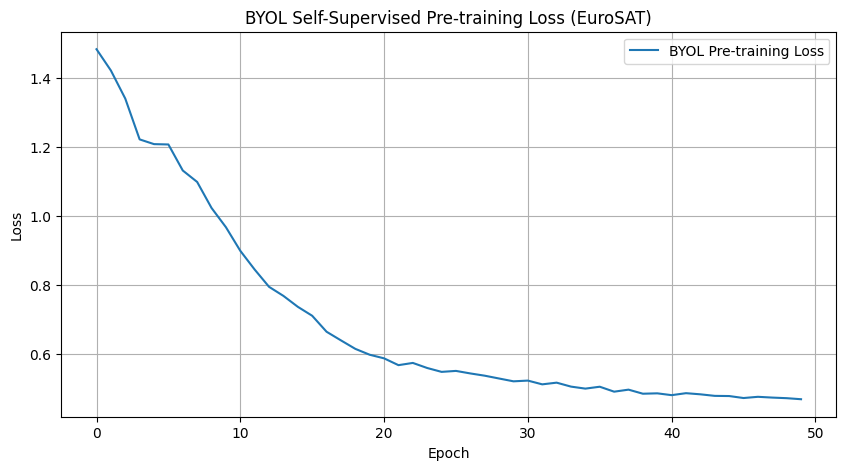

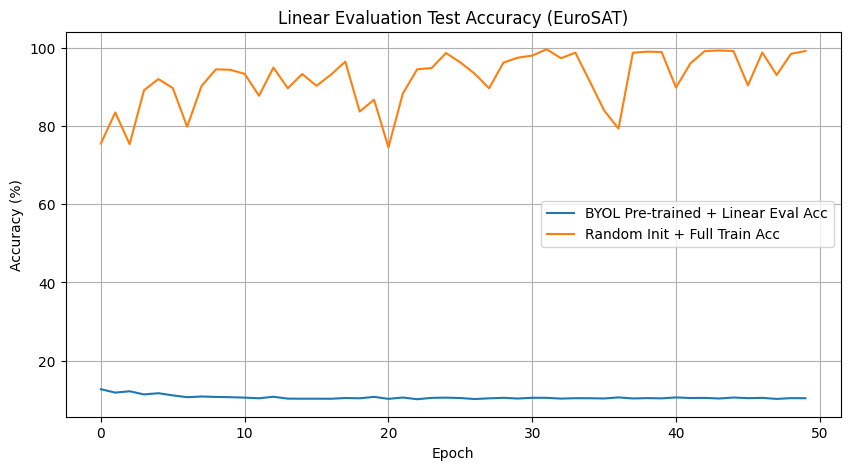


--- Visualizing Embedding Space with t-SNE ---
Running t-SNE on 27000 embeddings...


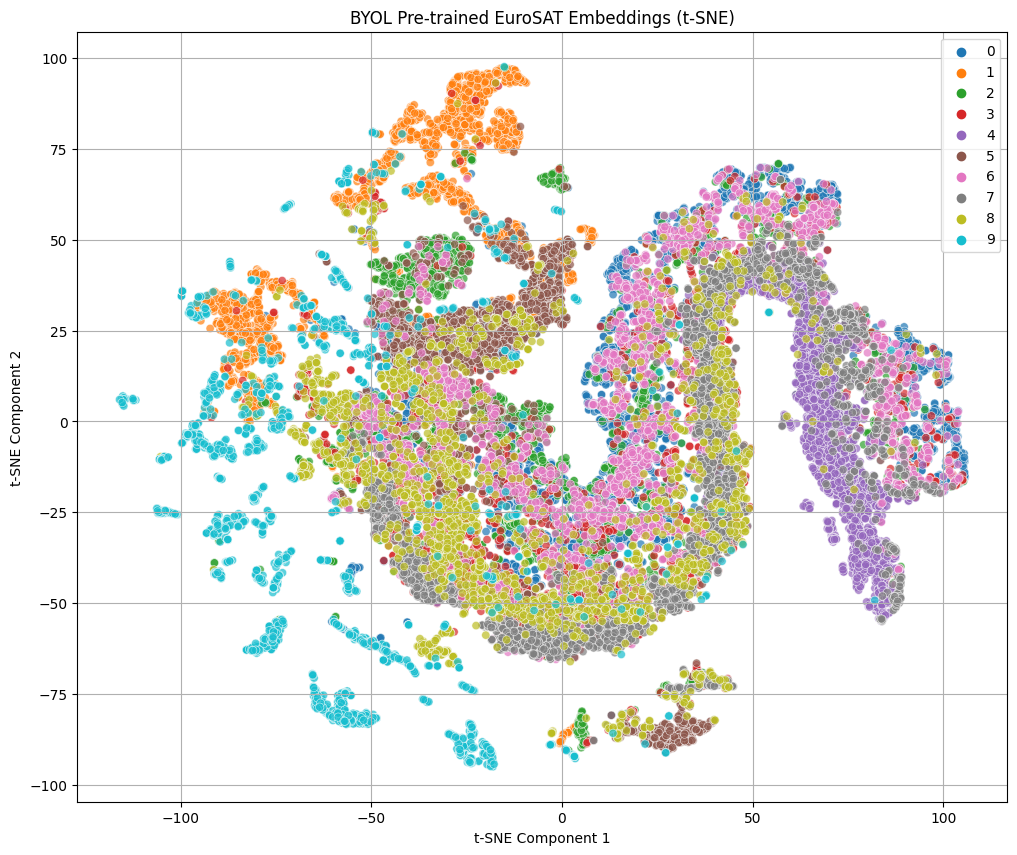


--- BYOL Visualization Summary ---
1. Final Linear Eval Accuracy (BYOL encoder): 10.38%
2. Final Accuracy (Random Init): 99.16%
3. t-SNE plot shows feature clusters learned via BYOL.

--- Discussing the Impact of BYOL ---
1. Self-Supervised Pre-training Loss Curve:
   - Show how the BYOL loss (a combination of MSE on normalized predictions) smoothly decreases, indicating the model is learning to predict the target network's output.
   - Emphasize that this happens *without any human labels*.
   - Contrast with supervised learning loss curves that rely on explicit labels.

2. Linear Evaluation Accuracy:
   - BYOL Pre-trained Encoder Accuracy: 10.38%
   - Randomly Initialized Encoder Accuracy: 99.16%
   - Highlight the significant performance gap.
   - Explain that BYOL's pre-training forces the encoder to learn *general-purpose, semantically rich features* (like edges, textures, object parts) that are useful for downstream tasks without ever seeing a single label.
   - Contrast with th

In [9]:
# Visualization of Impact (EuroSAT Dataset)

import seaborn as sns
from sklearn.manifold import TSNE

# --- Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses, label='BYOL Pre-training Loss')
plt.title('BYOL Self-Supervised Pre-training Loss (EuroSAT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "byol_pretrain_loss.png"))
plt.show()

# --- Linear Evaluation Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(linear_eval_test_accuracies, label='BYOL Pre-trained + Linear Eval Acc')
plt.plot(random_eval_test_accuracies, label='Random Init + Full Train Acc')
plt.title('Linear Evaluation Test Accuracy (EuroSAT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "linear_eval_accuracy.png"))
plt.show()

# --- Embedding Space Visualization (t-SNE) ---
print("\n--- Visualizing Embedding Space with t-SNE ---")

# Use entire test dataset if available
subset_dataset_eval = test_dataset_eval
subset_loader_eval = DataLoader(subset_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pretrained_encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in subset_loader_eval:
        images = images.to(DEVICE)
        features = pretrained_encoder(images)
        embeddings.append(features.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)

print(f"Running t-SNE on {embeddings.shape[0]} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting the t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=labels, palette=sns.color_palette("tab10", 10),
    legend='full', alpha=0.7
)
plt.title('BYOL Pre-trained EuroSAT Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "byol_embeddings_tsne.png"))
plt.show()

# --- Explain Results ---
print("\n--- BYOL Visualization Summary ---")
print(f"1. Final Linear Eval Accuracy (BYOL encoder): {linear_eval_test_accuracies[-1]:.2f}%")
print(f"2. Final Accuracy (Random Init): {random_eval_test_accuracies[-1]:.2f}%")
print("3. t-SNE plot shows feature clusters learned via BYOL.")

# --- Discussing the Impact of BYOL ---
print("\n--- Discussing the Impact of BYOL ---")

print("1. Self-Supervised Pre-training Loss Curve:")
print("   - Show how the BYOL loss (a combination of MSE on normalized predictions) smoothly decreases, indicating the model is learning to predict the target network's output.")
print("   - Emphasize that this happens *without any human labels*.")
print("   - Contrast with supervised learning loss curves that rely on explicit labels.")

print("\n2. Linear Evaluation Accuracy:")
print(f"   - BYOL Pre-trained Encoder Accuracy: {linear_eval_test_accuracies[-1]:.2f}%")
print(f"   - Randomly Initialized Encoder Accuracy: {random_eval_test_accuracies[-1]:.2f}%")
print("   - Highlight the significant performance gap.")
print("   - Explain that BYOL's pre-training forces the encoder to learn *general-purpose, semantically rich features* (like edges, textures, object parts) that are useful for downstream tasks without ever seeing a single label.")
print("   - Contrast with the 'random' baseline, which learns everything from scratch with limited labeled data.")

print("\n3. Embedding Space Visualization (t-SNE):")
print("   - Show the t-SNE plot where points are colored by their true EuroSAT classes.")
print("   - Point out that even though BYOL never saw these labels, images from the same class tend to *cluster together* in the embedding space.")
print("   - This visually demonstrates that the encoder has learned to group similar concepts.")
print("   - Explain that this 'clustering' means the representations are 'disentangled' or 'meaningful' for classification.")

print("\n4. Key Concepts of BYOL:")
print("   - No Negative Pairs: BYOL avoids the need for computationally expensive negative samples, unlike SimCLR or MoCo.")
print("   - Target Network & EMA: The target network is a slowly updated copy of the online network (EMA) and provides a stable prediction target.")
print("   - Predictor: Helps prevent collapse by predicting the target output, making sure the online encoder doesn’t trivially match it.")
print("   - Asymmetric Design: Online network has predictor; target uses EMA; target is stop-gradient.")

print("\nBy demonstrating these aspects, students can grasp the power of self-supervised learning,")
print("especially BYOL, in learning effective representations from unlabeled data — a critical skill in modern AI.")


